# Facial Expression Recognition

#### CSCA 5642 Introduction to Deep Learning Final

### Problem Description
* Facial expression recognition (FER) is a crucial area in computer vision and artificial intelligence, aimed at identifying human emotions from facial images. This notebook explores building a deep learning model to recognize facial expressions using the FER dataset.

### Exploratory Data Analysis

In [1]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-07-26 22:51:34.276170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('./fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [4]:
data.nunique()

emotion        7
pixels     34034
Usage          3
dtype: int64

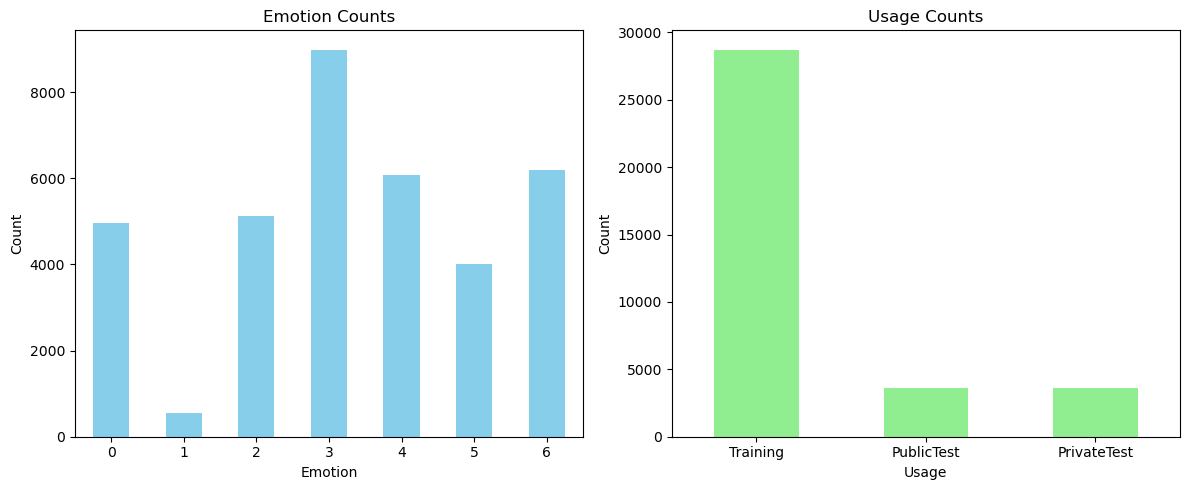

In [5]:
import matplotlib.pyplot as plt

emotion_counts = data['emotion'].value_counts().sort_index()

# Ensure the x-axis includes all values from 0 to 6
all_emotions = pd.Series(range(7))
emotion_counts = emotion_counts.reindex(all_emotions, fill_value=0)

# Count unique values in 'Usage' column
usage_counts = data['Usage'].value_counts()

# Plotting the emotion counts
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(range(7))
plt.xticks(rotation=0)

# Plotting the usage counts
plt.subplot(1, 2, 2)
usage_counts.plot(kind='bar', color='lightgreen')
plt.title('Usage Counts')
plt.xlabel('Usage')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [6]:
pixel_x = math.sqrt(len(data.pixels[0].split(' ')))
pixel_y = math.sqrt(len(data.pixels[1].split(' ')))

print('pixel_x:', pixel_x, 'pixel_y:', pixel_y)

pixel_x: 48.0 pixel_y: 48.0


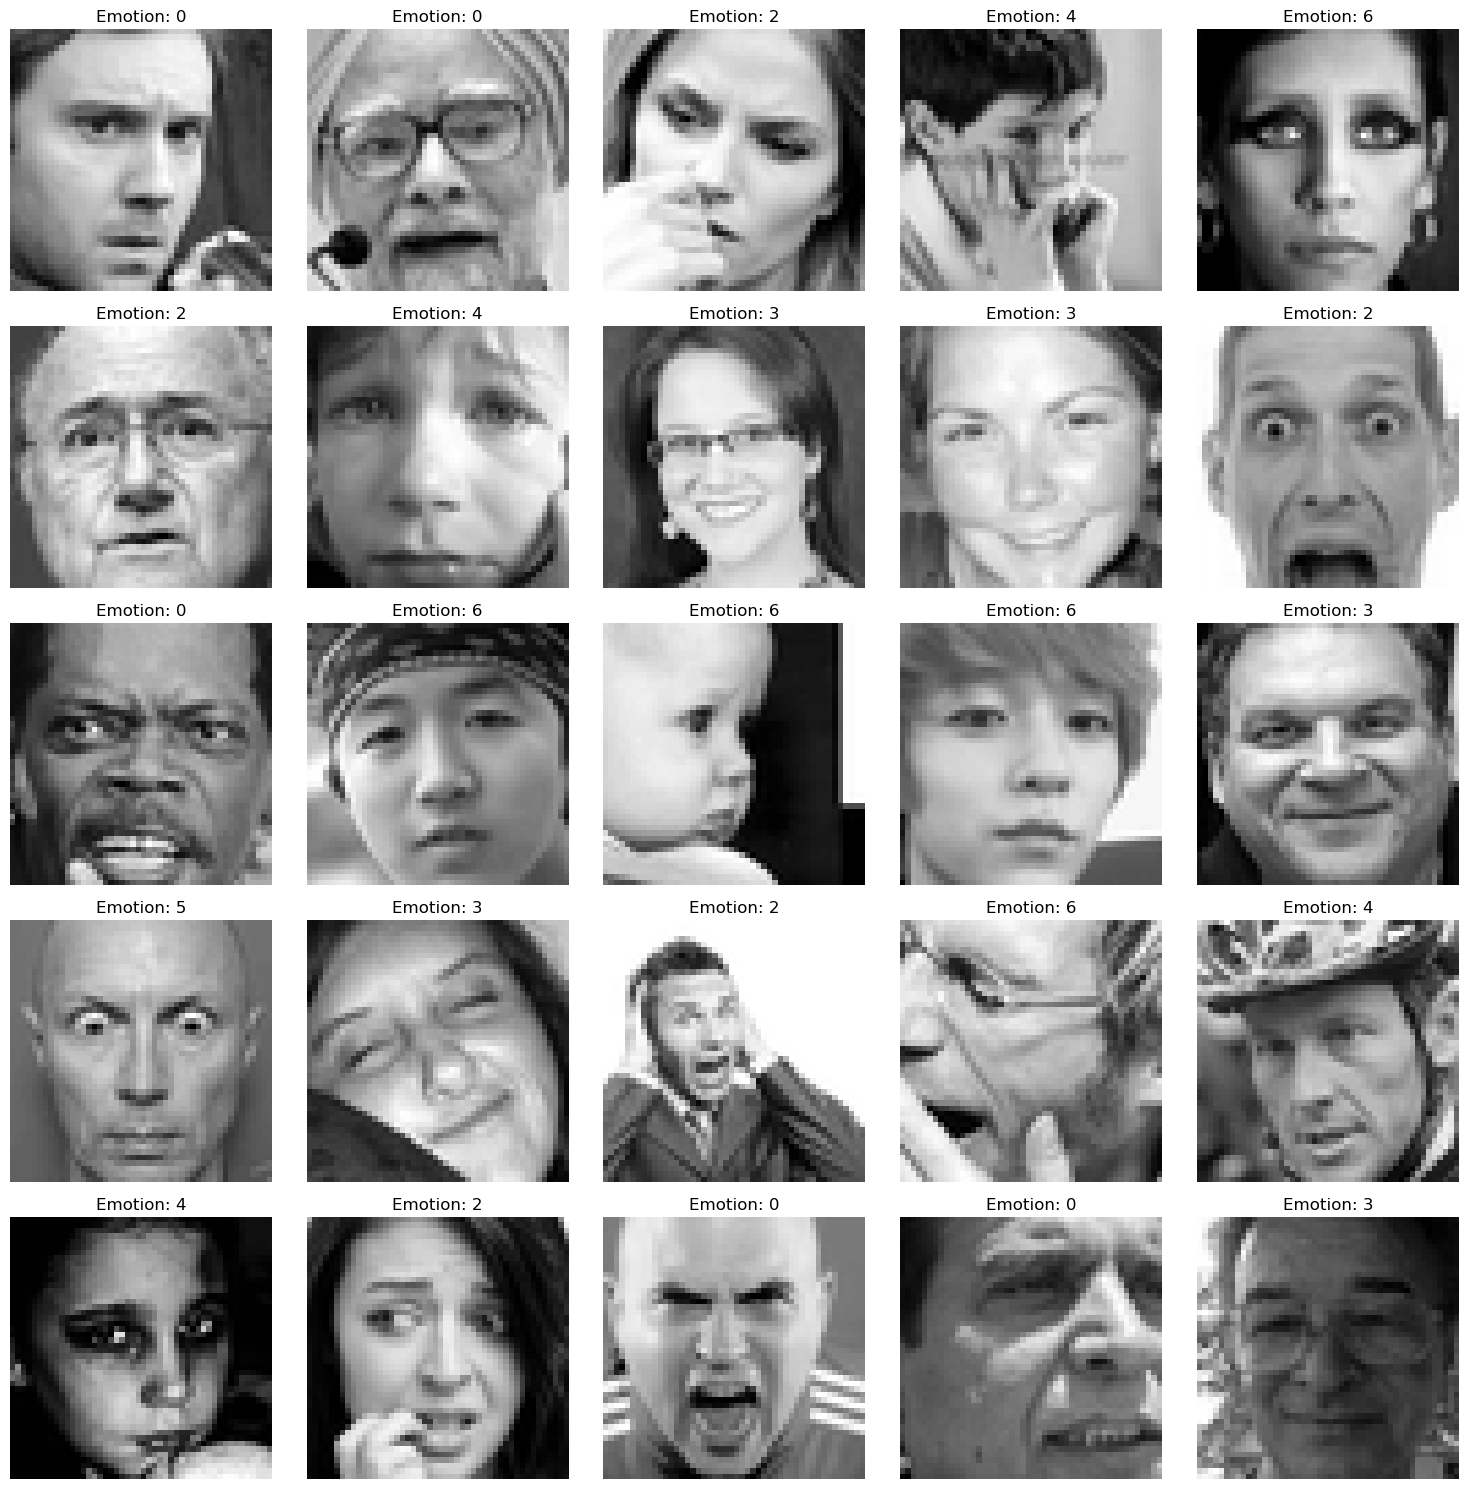

In [7]:
def show_faces(df, count):
    count = min(count, len(df))
    rows = (count + 4) // 5 
    plt.figure(figsize=(15, 3 * rows))

    for i in range(count):
        pixels = df.iloc[i]['pixels']
        emotion = df.iloc[i]['emotion']
        
        pixels_array = np.array([int(pixel) for pixel in pixels.split()]).reshape(int(pixel_x), int(pixel_y))

        plt.subplot(rows, 5, i + 1)
        plt.imshow(pixels_array, cmap='gray')
        plt.title(f'Emotion: {emotion}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
show_faces(data, 25)

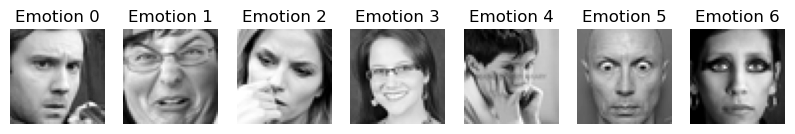

In [8]:
sampled_images = []
for emotion in range(7):
    sample_image = data[data['emotion'] == emotion].iloc[0]
    pixels = np.array(sample_image['pixels'].split(), dtype='float32')
    pixels = pixels.reshape(48, 48)  # Assuming the image size is 48x48 pixels
    sampled_images.append((emotion, pixels))

# Plot the images
plt.figure(figsize=(10, 5))
for idx, (emotion, image) in enumerate(sampled_images):
    plt.subplot(1, 7, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Emotion {emotion}')
    plt.axis('off')

plt.show()

In [9]:
emotion_label_to_text = {
    0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [10]:
# data = data.head(1000)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [11]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' '))
                              .reshape(int(pixel_x), int(pixel_y),1).astype('float32'))
img_array = np.stack(img_array, axis = 0)
img_array.shape

(35887, 48, 48, 1)

In [12]:
from keras.utils import to_categorical
le = LabelEncoder()

img_labels = le.fit_transform(data.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

### Model Building and Training

- Input Layer:
- Input shape: (48, 48, 1)
    - First Convolutional Block:
        - Conv2D(64) / BatchNormalization / Conv2D / BatchNormalization / MaxPooling2D / Dropout
    - Second Convolutional Block:
        - Conv2D(128) / BatchNormalization / Conv2D / BatchNormalization / MaxPooling2D / Dropout
    - Third Convolutional Block
        - Conv2D(256) / BatchNormalization / Conv2D / BatchNormalization / MaxPooling2D / Dropout
    - Fully Connected Layers:
        - Flatten / Dense / BatchNormalization / Dropout / Dense

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [14]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [15]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [16]:
net = Sequential(name='DCNN')

# First convolutional block
net.add(Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal', 
               input_shape=(img_width, img_height, img_depth), name='conv2d_1'))
net.add(BatchNormalization(name='batchnorm_1'))
net.add(Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_2'))
net.add(BatchNormalization(name='batchnorm_2'))
net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
net.add(Dropout(0.4, name='dropout_1'))

# Second convolutional block
net.add(Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_3'))
net.add(BatchNormalization(name='batchnorm_3'))
net.add(Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_4'))
net.add(BatchNormalization(name='batchnorm_4'))
net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
net.add(Dropout(0.4, name='dropout_2'))

# Third convolutional block
net.add(Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_5'))
net.add(BatchNormalization(name='batchnorm_5'))
net.add(Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_6'))
net.add(BatchNormalization(name='batchnorm_6'))
net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
net.add(Dropout(0.5, name='dropout_3'))

# Fully connected layers
net.add(Flatten(name='flatten'))
net.add(Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
net.add(BatchNormalization(name='batchnorm_7'))
net.add(Dropout(0.6, name='dropout_4'))
net.add(Dense(num_classes, activation='softmax', name='out_layer'))

# Compile the model
net.compile(loss='categorical_crossentropy', metrics=['accuracy'])
net.summary()

/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [19]:
batch_size = 32
epochs = 100

In [20]:
history = net.fit(train_datagen.flow(X_train, y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) // batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks)


Epoch 1/100


/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 619s 611ms/step - accuracy: 0.2011 - loss: 2.3980 - val_accuracy: 0.3296 - val_loss: 1.7493 - learning_rate: 0.0010
Epoch 2/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:46 641ms/step - accuracy: 0.2812 - loss: 1.8525

2024-07-26 23:02:46.413398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/chenliyang1024/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.2812 - loss: 1.8525 - val_accuracy: 0.3706 - val_loss: 1.6738 - learning_rate: 0.0010
Epoch 3/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 645s 639ms/step - accuracy: 0.3445 - loss: 1.6624 - val_accuracy: 0.4458 - val_loss: 1.4454 - learning_rate: 0.0010
Epoch 4/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 13:53 827ms/step - accuracy: 0.4062 - loss: 1.5330

2024-07-26 23:13:45.448378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.4062 - loss: 1.5330 - val_accuracy: 0.4397 - val_loss: 1.4480 - learning_rate: 0.0010
Epoch 5/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 661s 655ms/step - accuracy: 0.4299 - loss: 1.4813 - val_accuracy: 0.5163 - val_loss: 1.2697 - learning_rate: 0.0010
Epoch 6/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:13 669ms/step - accuracy: 0.5312 - loss: 1.4532

2024-07-26 23:25:03.326369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5312 - loss: 1.4532 - val_accuracy: 0.5249 - val_loss: 1.2537 - learning_rate: 0.0010
Epoch 7/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 664s 658ms/step - accuracy: 0.4791 - loss: 1.3775 - val_accuracy: 0.5336 - val_loss: 1.2414 - learning_rate: 0.0010
Epoch 8/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:13 609ms/step - accuracy: 0.5625 - loss: 1.3866

2024-07-26 23:36:23.006439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5625 - loss: 1.3866 - val_accuracy: 0.5447 - val_loss: 1.2220 - learning_rate: 0.0010
Epoch 9/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 648s 642ms/step - accuracy: 0.5042 - loss: 1.3156 - val_accuracy: 0.5609 - val_loss: 1.1629 - learning_rate: 0.0010
Epoch 10/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:31 626ms/step - accuracy: 0.5312 - loss: 1.2237

2024-07-26 23:47:25.841095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5312 - loss: 1.2237 - val_accuracy: 0.5545 - val_loss: 1.1768 - learning_rate: 0.0010
Epoch 11/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 653s 647ms/step - accuracy: 0.5231 - loss: 1.2729 - val_accuracy: 0.5773 - val_loss: 1.1161 - learning_rate: 0.0010
Epoch 12/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:52 647ms/step - accuracy: 0.5000 - loss: 1.2105

2024-07-26 23:58:33.793464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5000 - loss: 1.2105 - val_accuracy: 0.5793 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 13/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 660s 654ms/step - accuracy: 0.5367 - loss: 1.2355 - val_accuracy: 0.5860 - val_loss: 1.0800 - learning_rate: 0.0010
Epoch 14/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:12 668ms/step - accuracy: 0.6875 - loss: 1.0395

2024-07-27 00:09:49.668381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6875 - loss: 1.0395 - val_accuracy: 0.5938 - val_loss: 1.0750 - learning_rate: 0.0010
Epoch 15/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 659s 653ms/step - accuracy: 0.5510 - loss: 1.2088 - val_accuracy: 0.5979 - val_loss: 1.0709 - learning_rate: 0.0010
Epoch 16/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:15 670ms/step - accuracy: 0.7188 - loss: 1.0261

2024-07-27 00:21:04.624718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.7188 - loss: 1.0261 - val_accuracy: 0.5879 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 17/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 662s 656ms/step - accuracy: 0.5554 - loss: 1.1874 - val_accuracy: 0.5963 - val_loss: 1.0645 - learning_rate: 0.0010
Epoch 18/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:08 663ms/step - accuracy: 0.4375 - loss: 1.3320

2024-07-27 00:32:22.792653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4375 - loss: 1.3320 - val_accuracy: 0.6030 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 19/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 659s 653ms/step - accuracy: 0.5600 - loss: 1.1771 - val_accuracy: 0.5784 - val_loss: 1.0917 - learning_rate: 0.0010
Epoch 20/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:09 664ms/step - accuracy: 0.4062 - loss: 1.2522

2024-07-27 00:43:37.820959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4062 - loss: 1.2522 - val_accuracy: 0.5848 - val_loss: 1.0802 - learning_rate: 0.0010
Epoch 21/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 657s 651ms/step - accuracy: 0.5727 - loss: 1.1537 - val_accuracy: 0.6046 - val_loss: 1.0691 - learning_rate: 0.0010
Epoch 22/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:13 668ms/step - accuracy: 0.5938 - loss: 0.8813

2024-07-27 00:54:51.177996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5938 - loss: 0.8813 - val_accuracy: 0.6049 - val_loss: 1.0677 - learning_rate: 0.0010
Epoch 23/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 665s 658ms/step - accuracy: 0.5779 - loss: 1.1302 - val_accuracy: 0.6119 - val_loss: 1.0223 - learning_rate: 0.0010
Epoch 24/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:06 661ms/step - accuracy: 0.5000 - loss: 1.4432

2024-07-27 01:06:11.734602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5000 - loss: 1.4432 - val_accuracy: 0.6013 - val_loss: 1.0492 - learning_rate: 0.0010
Epoch 25/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 664ms/step - accuracy: 0.5811 - loss: 1.1253 - val_accuracy: 0.6213 - val_loss: 1.0040 - learning_rate: 0.0010
Epoch 26/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:15 671ms/step - accuracy: 0.6250 - loss: 1.0797

2024-07-27 01:17:38.512281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6250 - loss: 1.0797 - val_accuracy: 0.6222 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 27/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 672s 666ms/step - accuracy: 0.5848 - loss: 1.1150 - val_accuracy: 0.6222 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 28/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:22 677ms/step - accuracy: 0.5625 - loss: 1.1513

2024-07-27 01:29:06.898121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5625 - loss: 1.1513 - val_accuracy: 0.6280 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 29/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 673s 667ms/step - accuracy: 0.5894 - loss: 1.1074 - val_accuracy: 0.6247 - val_loss: 1.0127 - learning_rate: 0.0010
Epoch 30/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:16 671ms/step - accuracy: 0.5625 - loss: 1.0794

2024-07-27 01:40:36.758954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5625 - loss: 1.0794 - val_accuracy: 0.6255 - val_loss: 1.0055 - learning_rate: 0.0010
Epoch 31/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 668s 662ms/step - accuracy: 0.5884 - loss: 1.1024 - val_accuracy: 0.6311 - val_loss: 0.9770 - learning_rate: 0.0010
Epoch 32/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:49 645ms/step - accuracy: 0.5625 - loss: 1.2503

2024-07-27 01:52:01.548022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5625 - loss: 1.2503 - val_accuracy: 0.6216 - val_loss: 1.0010 - learning_rate: 0.0010
Epoch 33/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 670s 664ms/step - accuracy: 0.5961 - loss: 1.0893 - val_accuracy: 0.6199 - val_loss: 1.0067 - learning_rate: 0.0010
Epoch 34/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:18 673ms/step - accuracy: 0.5625 - loss: 1.1968

2024-07-27 02:03:27.452783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5625 - loss: 1.1968 - val_accuracy: 0.6219 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 35/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 669s 663ms/step - accuracy: 0.5974 - loss: 1.0752 - val_accuracy: 0.6264 - val_loss: 1.0140 - learning_rate: 0.0010
Epoch 36/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:50 646ms/step - accuracy: 0.5625 - loss: 1.0159

2024-07-27 02:14:52.590377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5625 - loss: 1.0159 - val_accuracy: 0.6202 - val_loss: 1.0237 - learning_rate: 0.0010
Epoch 37/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 665s 659ms/step - accuracy: 0.6060 - loss: 1.0694 - val_accuracy: 0.6325 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 38/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:07 662ms/step - accuracy: 0.7812 - loss: 0.8464

2024-07-27 02:26:13.559031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.7812 - loss: 0.8464 - val_accuracy: 0.6269 - val_loss: 1.0134 - learning_rate: 0.0010
Epoch 39/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 678s 672ms/step - accuracy: 0.6068 - loss: 1.0555 - val_accuracy: 0.6336 - val_loss: 0.9657 - learning_rate: 0.0010
Epoch 40/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:19 675ms/step - accuracy: 0.6562 - loss: 0.9763

2024-07-27 02:37:47.764331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6562 - loss: 0.9763 - val_accuracy: 0.6386 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 41/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 668s 662ms/step - accuracy: 0.6094 - loss: 1.0584 - val_accuracy: 0.6489 - val_loss: 0.9505 - learning_rate: 0.0010
Epoch 42/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:12 667ms/step - accuracy: 0.4375 - loss: 1.5516

2024-07-27 02:49:11.883557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4375 - loss: 1.5516 - val_accuracy: 0.6539 - val_loss: 0.9446 - learning_rate: 0.0010
Epoch 43/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 667s 661ms/step - accuracy: 0.6101 - loss: 1.0573 - val_accuracy: 0.6461 - val_loss: 0.9560 - learning_rate: 0.0010
Epoch 44/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:13 668ms/step - accuracy: 0.5938 - loss: 1.0784

2024-07-27 03:00:35.503986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5938 - loss: 1.0784 - val_accuracy: 0.6436 - val_loss: 0.9665 - learning_rate: 0.0010
Epoch 45/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 669s 663ms/step - accuracy: 0.6171 - loss: 1.0366 - val_accuracy: 0.6489 - val_loss: 0.9446 - learning_rate: 0.0010
Epoch 46/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:10 666ms/step - accuracy: 0.4688 - loss: 1.3664

2024-07-27 03:12:01.443852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4688 - loss: 1.3664 - val_accuracy: 0.6506 - val_loss: 0.9448 - learning_rate: 0.0010
Epoch 47/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 665ms/step - accuracy: 0.6196 - loss: 1.0341 - val_accuracy: 0.6422 - val_loss: 0.9590 - learning_rate: 0.0010
Epoch 48/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:12 667ms/step - accuracy: 0.6250 - loss: 1.0024

2024-07-27 03:23:28.804736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6250 - loss: 1.0024 - val_accuracy: 0.6486 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 49/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.6200 - loss: 1.0300
Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 678s 671ms/step - accuracy: 0.6200 - loss: 1.0300 - val_accuracy: 0.6389 - val_loss: 0.9766 - learning_rate: 0.0010
Epoch 50/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:35 690ms/step - accuracy: 0.5625 - loss: 0.9870

2024-07-27 03:35:02.740762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5625 - loss: 0.9870 - val_accuracy: 0.6381 - val_loss: 0.9758 - learning_rate: 5.0000e-04
Epoch 51/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 672s 666ms/step - accuracy: 0.6299 - loss: 1.0140 - val_accuracy: 0.6573 - val_loss: 0.9352 - learning_rate: 5.0000e-04
Epoch 52/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:08 664ms/step - accuracy: 0.6250 - loss: 0.9665

2024-07-27 03:46:31.607397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6250 - loss: 0.9665 - val_accuracy: 0.6570 - val_loss: 0.9328 - learning_rate: 5.0000e-04
Epoch 53/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 666s 660ms/step - accuracy: 0.6343 - loss: 0.9948 - val_accuracy: 0.6629 - val_loss: 0.9291 - learning_rate: 5.0000e-04
Epoch 54/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:07 662ms/step - accuracy: 0.6875 - loss: 0.8016

2024-07-27 03:57:54.558240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6875 - loss: 0.8016 - val_accuracy: 0.6662 - val_loss: 0.9280 - learning_rate: 5.0000e-04
Epoch 55/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 669s 663ms/step - accuracy: 0.6377 - loss: 0.9816 - val_accuracy: 0.6570 - val_loss: 0.9517 - learning_rate: 5.0000e-04
Epoch 56/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:23 679ms/step - accuracy: 0.7188 - loss: 0.8625

2024-07-27 04:09:20.106444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.7188 - loss: 0.8625 - val_accuracy: 0.6581 - val_loss: 0.9437 - learning_rate: 5.0000e-04
Epoch 57/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 667s 661ms/step - accuracy: 0.6326 - loss: 1.0015 - val_accuracy: 0.6556 - val_loss: 0.9188 - learning_rate: 5.0000e-04
Epoch 58/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 12:53 768ms/step - accuracy: 0.5938 - loss: 1.0506

2024-07-27 04:20:43.809939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5938 - loss: 1.0506 - val_accuracy: 0.6537 - val_loss: 0.9273 - learning_rate: 5.0000e-04
Epoch 59/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 665ms/step - accuracy: 0.6407 - loss: 0.9832 - val_accuracy: 0.6606 - val_loss: 0.9409 - learning_rate: 5.0000e-04
Epoch 60/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:32 687ms/step - accuracy: 0.6875 - loss: 0.8476

2024-07-27 04:32:10.949680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6875 - loss: 0.8476 - val_accuracy: 0.6609 - val_loss: 0.9412 - learning_rate: 5.0000e-04
Epoch 61/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.6447 - loss: 0.9698
Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 680s 673ms/step - accuracy: 0.6447 - loss: 0.9698 - val_accuracy: 0.6615 - val_loss: 0.9210 - learning_rate: 5.0000e-04
Epoch 62/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:07 662ms/step - accuracy: 0.7188 - loss: 0.9773

2024-07-27 04:43:47.883973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7188 - loss: 0.9773 - val_accuracy: 0.6604 - val_loss: 0.9205 - learning_rate: 2.5000e-04
Epoch 63/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 672s 666ms/step - accuracy: 0.6470 - loss: 0.9644 - val_accuracy: 0.6656 - val_loss: 0.9093 - learning_rate: 2.5000e-04
Epoch 64/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:28 683ms/step - accuracy: 0.6875 - loss: 0.8315

2024-07-27 04:55:16.395781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6875 - loss: 0.8315 - val_accuracy: 0.6651 - val_loss: 0.9113 - learning_rate: 2.5000e-04
Epoch 65/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 672s 666ms/step - accuracy: 0.6487 - loss: 0.9570 - val_accuracy: 0.6665 - val_loss: 0.9119 - learning_rate: 2.5000e-04
Epoch 66/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 12:26 740ms/step - accuracy: 0.6875 - loss: 0.8173

2024-07-27 05:06:45.050591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6875 - loss: 0.8173 - val_accuracy: 0.6623 - val_loss: 0.9132 - learning_rate: 2.5000e-04
Epoch 67/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 673s 667ms/step - accuracy: 0.6466 - loss: 0.9613 - val_accuracy: 0.6712 - val_loss: 0.9012 - learning_rate: 2.5000e-04
Epoch 68/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 13:45 819ms/step - accuracy: 0.5625 - loss: 1.2583

2024-07-27 05:18:14.839678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5625 - loss: 1.2583 - val_accuracy: 0.6718 - val_loss: 0.9014 - learning_rate: 2.5000e-04
Epoch 69/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 674s 667ms/step - accuracy: 0.6546 - loss: 0.9447 - val_accuracy: 0.6651 - val_loss: 0.9265 - learning_rate: 2.5000e-04
Epoch 70/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:33 688ms/step - accuracy: 0.6562 - loss: 1.1710

2024-07-27 05:29:45.726086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6562 - loss: 1.1710 - val_accuracy: 0.6654 - val_loss: 0.9237 - learning_rate: 2.5000e-04
Epoch 71/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 669s 662ms/step - accuracy: 0.6562 - loss: 0.9488 - val_accuracy: 0.6682 - val_loss: 0.9222 - learning_rate: 2.5000e-04
Epoch 72/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:54 709ms/step - accuracy: 0.5625 - loss: 1.1129

2024-07-27 05:41:10.832670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5625 - loss: 1.1129 - val_accuracy: 0.6682 - val_loss: 0.9201 - learning_rate: 2.5000e-04
Epoch 73/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 670s 664ms/step - accuracy: 0.6519 - loss: 0.9548 - val_accuracy: 0.6679 - val_loss: 0.9213 - learning_rate: 2.5000e-04
Epoch 74/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:44 699ms/step - accuracy: 0.5625 - loss: 0.9035

2024-07-27 05:52:36.896794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5625 - loss: 0.9035 - val_accuracy: 0.6673 - val_loss: 0.9216 - learning_rate: 2.5000e-04
Epoch 75/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 665ms/step - accuracy: 0.6532 - loss: 0.9433 - val_accuracy: 0.6721 - val_loss: 0.9058 - learning_rate: 2.5000e-04
Epoch 76/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:36 691ms/step - accuracy: 0.6562 - loss: 0.8467

2024-07-27 06:04:04.282438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6562 - loss: 0.8467 - val_accuracy: 0.6718 - val_loss: 0.9054 - learning_rate: 2.5000e-04
Epoch 77/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 665ms/step - accuracy: 0.6514 - loss: 0.9482 - val_accuracy: 0.6682 - val_loss: 0.9103 - learning_rate: 2.5000e-04
Epoch 78/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:27 682ms/step - accuracy: 0.5625 - loss: 0.8202

2024-07-27 06:15:31.975649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5625 - loss: 0.8202 - val_accuracy: 0.6668 - val_loss: 0.9082 - learning_rate: 2.5000e-04
Epoch 79/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 665ms/step - accuracy: 0.6514 - loss: 0.9480 - val_accuracy: 0.6695 - val_loss: 0.9141 - learning_rate: 2.5000e-04
Epoch 80/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:30 685ms/step - accuracy: 0.7812 - loss: 0.6595

2024-07-27 06:26:59.653367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7812 - loss: 0.6595 - val_accuracy: 0.6704 - val_loss: 0.9120 - learning_rate: 2.5000e-04
Epoch 81/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 674s 668ms/step - accuracy: 0.6637 - loss: 0.9320 - val_accuracy: 0.6665 - val_loss: 0.9267 - learning_rate: 2.5000e-04
Epoch 82/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:16 671ms/step - accuracy: 0.8125 - loss: 0.6304

2024-07-27 06:38:30.304906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8125 - loss: 0.6304 - val_accuracy: 0.6640 - val_loss: 0.9276 - learning_rate: 2.5000e-04
Epoch 83/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 671s 665ms/step - accuracy: 0.6562 - loss: 0.9373 - val_accuracy: 0.6695 - val_loss: 0.9110 - learning_rate: 1.2500e-04
Epoch 84/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:31 686ms/step - accuracy: 0.7188 - loss: 0.8674

2024-07-27 06:49:58.072092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.7188 - loss: 0.8674 - val_accuracy: 0.6709 - val_loss: 0.9106 - learning_rate: 1.2500e-04
Epoch 85/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 675s 669ms/step - accuracy: 0.6617 - loss: 0.9213 - val_accuracy: 0.6709 - val_loss: 0.9022 - learning_rate: 1.2500e-04
Epoch 86/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:32 687ms/step - accuracy: 0.7188 - loss: 0.7820

2024-07-27 07:01:29.173791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.7188 - loss: 0.7820 - val_accuracy: 0.6715 - val_loss: 0.9021 - learning_rate: 1.2500e-04
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 75.


/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

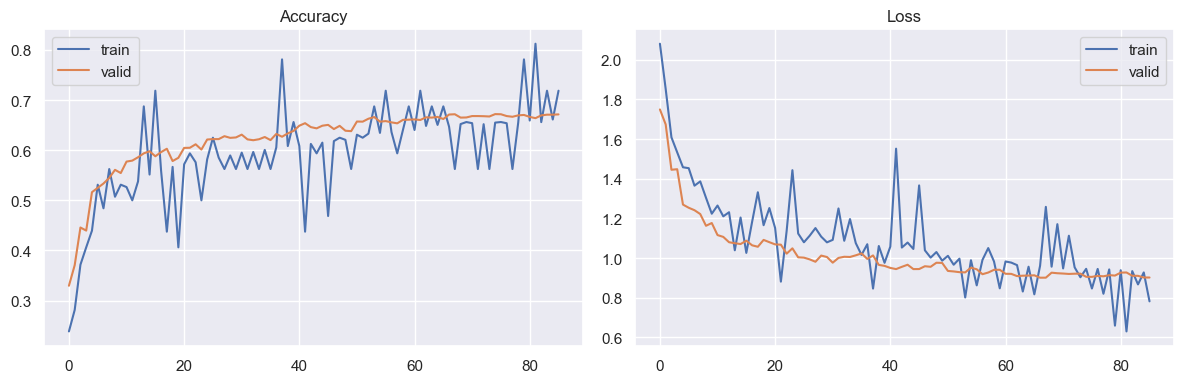

In [21]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

# pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

### Result & Prediction

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

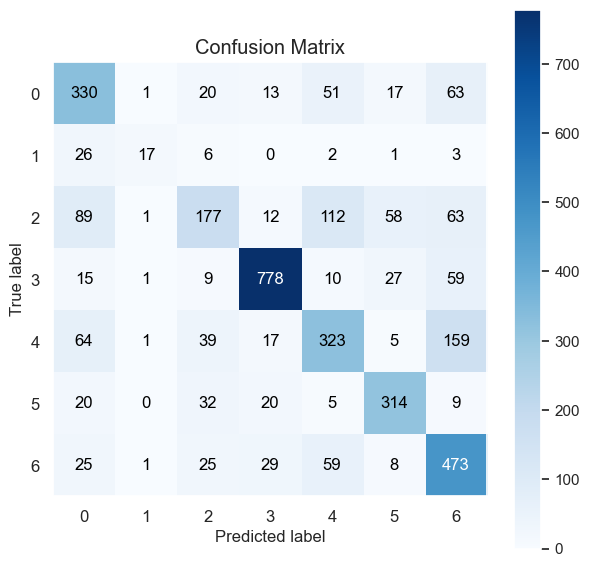

In [22]:
yhat_valid = np.argmax(net.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))

#### What problem do you solve?
    Facial expression recognition (FER) is a crucial area in computer vision and artificial intelligence, aimed at identifying human emotions from facial images. By automating the recognition of facial expressions, this technology addresses various applications such as enhancing human-computer interaction, improving accessibility for individuals with disabilities, and contributing to security and surveillance systems. FER can also play a significant role in psychological studies, market research, and entertainment industries by providing insights into human emotional responses.

#### What ML approach do you use, or what methods does your app use?
    This notebook explores building a deep learning model to recognize facial expressions using the FER dataset. The model architecture involves multiple convolutional blocks and fully connected layers. The input layer takes in grayscale images of shape (48, 48, 1). The first convolutional block includes Conv2D(64), BatchNormalization, another Conv2D, BatchNormalization, MaxPooling2D, and Dropout. The second block consists of Conv2D(128), BatchNormalization, another Conv2D, BatchNormalization, MaxPooling2D, and Dropout. The third block has Conv2D(256), BatchNormalization, another Conv2D, BatchNormalization, MaxPooling2D, and Dropout. The fully connected layers involve Flatten, Dense, BatchNormalization, Dropout, and another Dense layer. This structure ensures effective feature extraction and classification of facial expressions.